In [ ]:
#reproduces all panels of Figure 4, and Supp 5

eigengenes
enrichments
gradients


plotting


In [ ]:
import numpy as np
import nibabel as nb
import os
import matplotlib.pyplot as plt
from scripts.wgcna_module_enrichments import WGCNApostprocessing

concat= np.load('/data1/allen_surfaces/hcp_surfs_2/all_subs_smoothed_z.npy')

base_dir = '/data1/allen_surfaces/'
cortex=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
cortex=cortex.darrays[0].data>0
concat_cortex = concat[:,cortex]
del concat

proc = WGCNApostprocessing()

print('eigengenes')
proc.get_kme_and_eigengenes(concat_cortex)
del concat_cortex

proc.calc_filtered_modules()

proc.filter_out_genes_and_modules()

print('enrichments')
matrices=[]
matrices_for_clustering = ['Layer','Cell','Compartment',
                        'SynGO' ]
labels=[]
for m in matrices_for_clustering:
    f_mat,p_mat = proc.get_enrichment_for_prefix(m)
    matrices.append(p_mat)
    label = proc.generate_labels_from_prefixes(m)
    labels.append(label)

#here we're actually doing it from a previous ordering. Not ideal, but hey ho
order_matrices = np.hstack(matrices[:3])
new_order=proc.reorder_modules_from_similarity(order_matrices,
                                              from_file='/data1/bigbrain/phate_testing/wgcna/new_order.npy')


print('gradients')
proc.filter_eigengenes_and_grads(new_order)
print('plotting')


proc.get_dict_modules()
#ppi_mat=proc.get_ppis()

#plotting figures


In [4]:

def hex2rgb(hex_c):
    h=hex_c.lstrip('#')
    return np.array(tuple(int(h[i:i+2], 16) for i in (0, 2, 4)))

module_colors = np.ones((2,4))

module_colors[0,:3] = hex2rgb('#f69418')/255
module_colors[1,:3] = hex2rgb('#c190bc')/255

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-10-09) 47,313 Terms
HMS:0:00:02.875856 336,356 annotations, 20,586 genes, 18,410 GOs, 1 taxids READ: gene2go 

Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a


17 GO IDs NOT FOUND IN ASSOCIATION: GO:0045713 GO:1903759 GO:0045212 GO:0051186 GO:0010869 GO:0010870 GO:0001302 GO:0051088 GO:0010871 GO:0045715 GO:0045189 GO:0045714 GO:1900062 GO:0051181 GO:0032800 GO:0045716 GO:0009108


 80% 16,621 of 20,781 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 84% 17,496 of 20,781 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a


2 GO IDs NOT FOUND IN ASSOCIATION: GO:0005623 GO:0042643
3 GO IDs NOT FOUND IN ASSOCIATION: GO:0051184 GO:0048037 GO:0050662


 80% 16,538 of 20,781 population items found in association
44
M12 GER 0.6781110733537816
18
M12 NC 0.0011899921319606798
121
M15 GER 3.7971316228311594e-08
8
M15 NC 0.9506886571377352


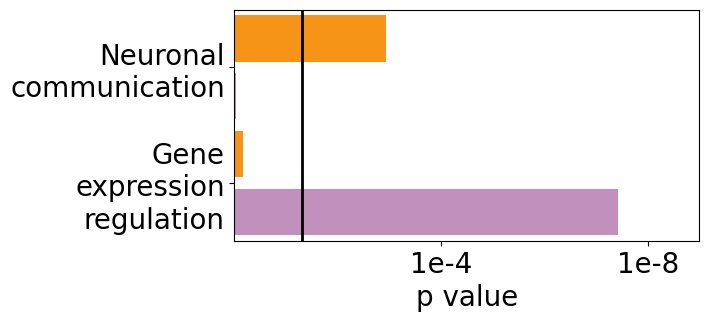

In [5]:
import pandas as pd

from goatools.base import get_godag
taxid=9606
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

# download associations
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations()

# load ontology
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

# load human gene ontology
from goatools.anno.genetogo_reader import Gene2GoReader
objanno = Gene2GoReader(fin_gene2go, taxids=[taxid]) #9606 is taxonomy ID for homo sapiens
ns2assoc = objanno.get_ns2assc()
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
#df_genehumans = pd.read_csv('data/df_human_geneinfo.csv',index_col=0)
df = pd.read_csv('armin_data/donor10021_preprocessed/donor10021_genes.ra.csv')
# if no reference list is given, default to all genes in ABHA

    #ref_list = np.union1d(df['gene.entrez_id'],df_genehumans['GeneID']).tolist()
ref_list = df['gene.entrez_id'].tolist()
    #ref_list = df_genehumans['GeneID'].to_list()

#logging can be turned off here somehow
goeaobj = GOEnrichmentStudyNS(ref_list, ns2assoc, obodag, 
                              propagate_counts=True, alpha=0.05, methods=['fdr_bh'])
symbol2id_dict = dict(zip(df['gene.symbol'].str.upper(), df['gene.entrez_id']))
id2symbol = dict(zip( df['gene.entrez_id'],df['gene.symbol'].str.upper()))
#terms from satterstrom
go_terms_of_interest={'GER':'GO:0006357',
'NC':'GO:0007268'}
# #dendrite
genes_in_term=[]
bool_term= np.zeros((2,len(df)),dtype=bool)
for si,sat_term  in enumerate(go_terms_of_interest.keys()):
    for gene in ns2assoc['BP']:
        if go_terms_of_interest[sat_term] in ns2assoc['BP'][gene]:
            try:
                genes_in_term.append(id2symbol[gene])
                bool_term[si,df['gene.symbol']==id2symbol[gene]]=1
            except KeyError:
                pass
from scipy import stats
def binary_enrichment(vec,bin_module):
    cross_tab = stats.contingency.crosstab(vec,bin_module)[1]
    print(cross_tab[1,1])
    f,fishers_p=stats.fisher_exact(cross_tab,alternative='greater')
    return fishers_p

mask=proc.gene_mask
masked_bool_term = bool_term[:,mask]
f_p = np.zeros((2,2))
for mi,module in enumerate(['M12','M15']):
    module_vec =np.zeros(sum(proc.gene_mask),dtype=bool)
    module_vec[proc.dictionary_modules[module]]=1
    for si,sat_term  in enumerate(go_terms_of_interest.keys()):
        #fishers test
        f_p[mi,si]= binary_enrichment(module_vec,masked_bool_term[si])
        print(module,sat_term,f_p[mi,si])
import matplotlib.ticker as mtick
from decimal import *

fig,ax = plt.subplots(1,1,figsize=(6,3))
positions = np.array([1,0,3,2])
colors= np.vstack([module_colors[0],module_colors[1],module_colors[0],module_colors[1],])

ax.barh(positions,-np.log10(f_p.T.ravel()),color=colors)
ax.set_yticks([0.5,2.5])
ax.set_yticklabels(['Gene\nexpression\nregulation','Neuronal\ncommunication'],size=20)
ax.plot([-np.log10(0.05),-np.log10(0.05),],[-0.8,4.8],c='k',lw=2)
ax.set_ylim([-0.5,3.5])

tcs=[1e-4,1e-8]
stcs = ["{:.0e}".format(Decimal(x)) for x in tcs]
ax.set_xticks(-np.log10(tcs))
ax.set_xticklabels(stcs,size=20)
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.set_xlim([0,9])
#ax.xticklabel_format(style='sci')
ax.set_xlabel('p value',size=20)
fig.savefig('figures/go_disease_asd.pdf')

In [6]:
from scripts.prepare_gene_lists.gene_mapping import get_indices
import gzip
import matplotlib_surface_plotting as msp
import scripts.paths as p

In [7]:
concat= np.load('/data1/allen_surfaces/hcp_surfs_2/all_subs_smoothed_z.npy')
cortex=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
cortex=cortex.darrays[0].data>0
concat_cortex = concat[:,cortex]
del concat

In [8]:

surf=nb.load(os.path.join(p.fs_LR32k_dir,
                                'fs_LR.32k.L.inflated.surf.gii'))

In [9]:
filtered_genes=concat_cortex[proc.gene_mask]

In [10]:
disease_gene_indices = np.hstack([proc.dictionary_modules['M12'],
                                  proc.dictionary_modules['M15']])
labels = np.hstack([np.zeros_like(proc.dictionary_modules['M12']),
                                  np.ones_like(proc.dictionary_modules['M15'])]).astype(bool)
kme12=np.corrcoef(proc.full_eigengenes_filtered[11][cortex],
            filtered_genes[disease_gene_indices])[0,1:]
kme15=np.corrcoef(proc.full_eigengenes_filtered[14][cortex],
            filtered_genes[disease_gene_indices])[0,1:]


In [11]:
#network
corr_grid=np.corrcoef(filtered_genes[disease_gene_indices])

In [12]:
#try circle nucleus, triangle synapse

shapes=masked_bool_term[:,disease_gene_indices]


mshapes=["s","^"]

In [19]:
genes_tables = pd.read_csv('all_gene_lists.csv')
asd_genes = genes_tables['Rare ASD']
asd_genes = asd_genes[proc.gene_mask]
asd_inds = np.where(asd_genes)[0]

In [21]:
asd_genes = np.zeros_like(disease_gene_indices,dtype=bool)
for dgi in disease_gene_indices:
    if dgi in asd_inds:
        asd_genes[disease_gene_indices==dgi]=1

0.4
0.3
0.5
0.1
0.7
0.2
0.6
0.9
0.8
0.0


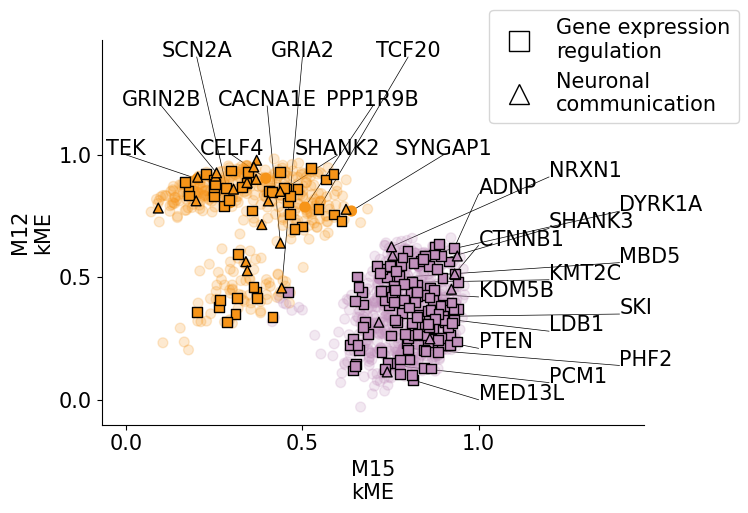

In [22]:
fig,ax = plt.subplots(1,figsize=(7,5))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
#add text of asd genes
m_d_gene_names=proc.gene_info['gene.symbol'][disease_gene_indices][asd_genes]
no_shape=~shapes.any(axis=0)
ax.scatter(kme15[no_shape],kme12[no_shape],c=module_colors[labels.astype(int)][no_shape],
           alpha=0.2+0.8*asd_genes[no_shape],
           s = 50, #+50*asd_genes[no_shape],
           #edgecolors=(np.array([0,0,0,0]).reshape(-1,1)*asd_genes[no_shape]).T,
           zorder=2)

handles=['Gene expression\nregulation','Neuronal\ncommunication']
for si,s in enumerate(mshapes):
    ax.scatter(kme15[shapes[si]],kme12[shapes[si]],
               c=module_colors[labels.astype(int)][shapes[si]],
               alpha=1, #asd_genes[shapes[si]],
             s = 50, #+50*asd_genes[shapes[si]],
               marker=s,
               edgecolors=((np.array([0,0,0,1]).reshape(-1,1)*shapes[si]).T)[shapes[si]],
           zorder=2,)
    #b=ax.scatter([0],[0],c='white',marker=s,label=handles[si])
    
#M12 across the top
jitter=kme15[np.logical_and(asd_genes,~labels)].argsort().argsort()
texts=[]
for gi,gene_name in enumerate(m_d_gene_names[~labels[asd_genes]]):
    kme15_score = kme15[np.logical_and(asd_genes,~labels)][gi]
    kme12_score = kme12[np.logical_and(asd_genes,~labels)][gi]
    x=kme15_score+jitter[gi]*0.01
    x=jitter[gi]/10
    print(x)
    y = 1+0.2*(jitter[gi]%3)
    ax.text(x,y,gene_name, rotation=0,transform=ax.transData,ha='center')
    ax.plot([kme15_score,x],[kme12_score,y],c='k',lw=0.5,
           zorder=1)
  #  texts.append(ax.text(x,y,gene_name,rotation=0,transform=ax.transData))
#ax.set_ylim([0,2])
# adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
#     ax.text(x,y,gene_name, rotation=45,transform=ax.transData)
#     ax.plot([kme15_score,x],[kme12_score,y],c='k',
 #          zorder=1)
jitter=kme12[np.logical_and(asd_genes,labels)].argsort().argsort()
for gi,gene_name in enumerate(m_d_gene_names[labels[asd_genes]]):
    kme15_score = kme15[np.logical_and(asd_genes,labels)][gi]
    kme12_score = kme12[np.logical_and(asd_genes,labels)][gi]
    y=jitter[gi]*0.07
    x=1+0.2*(jitter[gi]%3)
    #y=(y-kme12[labels].min())/(kme12[labels].max()-kme12[labels].min())
   # texts.append(ax.text(kme15_score,kme12_score,gene_name,rotation=0,transform=ax.transData))
    ax.text(x,y,gene_name, rotation=0,transform=ax.transData,
           ha='left')
    ax.plot([kme15_score,x],[kme12_score,y],c='k',lw=0.5,
           zorder=1)
#adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))



ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('M15\nkME')
ax.set_ylabel('M12\nkME')
from matplotlib.lines import Line2D

legend_elements = [#Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker=mshapes[0], color='w', label=handles[0],
                          markeredgecolor='k',
                          markerfacecolor='w', markersize=15),
                   Line2D([0], [0], marker=mshapes[1], color='w', label=handles[1],
                          markeredgecolor='k',
                          markerfacecolor='w', markersize=15),]

fig.legend(handles=legend_elements,bbox_to_anchor=(1.05,.96))

fig.savefig('figures/disease_mods_kme.pdf')

In [23]:
corrs12=np.corrcoef(proc.full_eigengenes_filtered[11,cortex],
            concat_cortex[genes_tables['Rare ASD']])[0,1:]
corrs15=np.corrcoef(proc.full_eigengenes_filtered[14,cortex],
            concat_cortex[genes_tables['Rare ASD']])[0,1:]
go_terms = bool_term[:,genes_tables['Rare ASD']]
c = go_terms[0].astype(int)+go_terms[1].astype(int)*2
c = np.clip(c,0,2)


In [24]:
go_genes=np.vstack([go_terms[0].astype(int),go_terms[1].astype(int)])
go_genes[0]=go_genes[0]*-1

In [29]:
from sknetwork.clustering import Louvain
from sklearn import mixture
gmm = mixture.GaussianMixture(
            n_components=2, covariance_type='full',random_state=1)

grid = np.corrcoef(concat_cortex[genes_tables['Rare ASD']])
#grid[grid<0]=0
# louvain = Louvain(random_state=0)
# edge_list = []
# for ci1,c1 in enumerate(np.arange(grid.shape[0])):
#     for ci2,c2 in enumerate(np.arange(grid.shape[0])):
#         edge_list.append((ci1,ci2,grid[ci1,ci2]))
        
# from sknetwork.utils import edgelist2adjacency
# adjacency = edgelist2adjacency(edge_list)
# labels = louvain.fit_transform(adjacency)
labels=gmm.fit_predict(grid)
#labels=np.hstack([labels,np.ones(10)*(np.max(labels)+1)]).astype(int)
for_sorting = labels+c/10
order_dg  = np.argsort(for_sorting)

In [30]:
im_bar=np.expand_dims(module_colors[labels[order_dg]],axis=1)

In [31]:
import scripts.paths as p

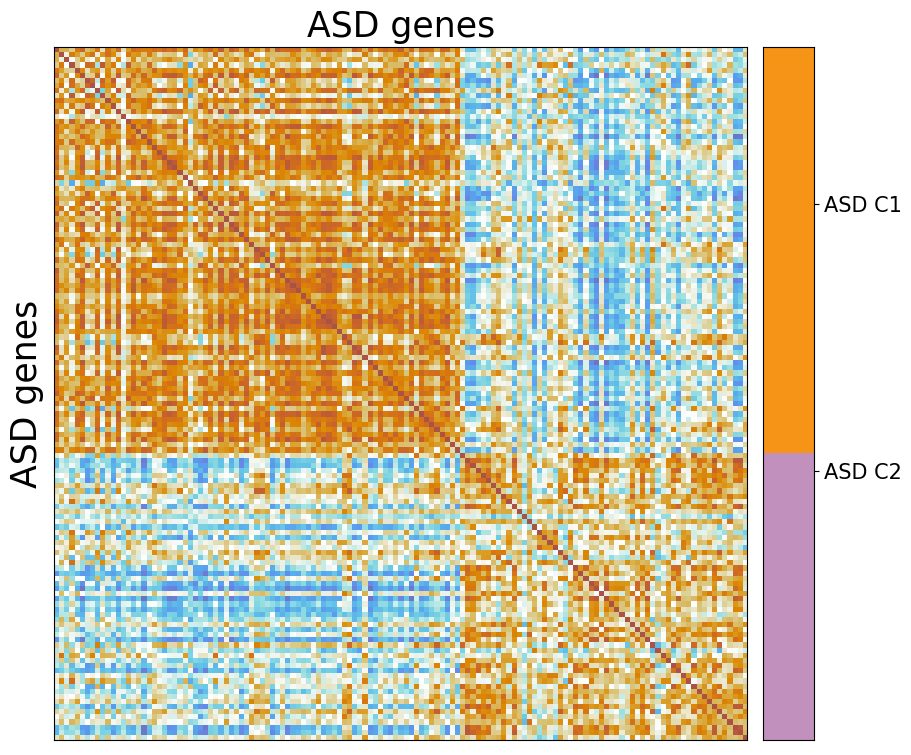

In [32]:
grid2 = np.corrcoef(concat_cortex[genes_tables['Rare ASD']])
fig = plt.figure(figsize=(10,9))
gs = fig.add_gridspec(1,2, wspace=0,width_ratios=[1,0.1],height_ratios=[1])
axs = gs.subplots(sharex=False, sharey=False)

axs[0].matshow(grid2[order_dg][:,order_dg],
               cmap=p.cmap_hex,vmin=-1,vmax=1)
axs[0].set_xticks([])
axs[1].imshow(im_bar)
axs[1].set_aspect(0.1)
axs[1].set_xticks([]);
axs[0].set_yticks([]);
axs[0].set_xlabel('ASD genes',fontsize=25)
axs[0].set_ylabel('ASD genes',fontsize=25,)
axs[0].xaxis.set_label_position('top') 
axs[1].set_yticks([30,82])
axs[1].set_yticklabels(['ASD C1','ASD C2'])
axs[1].yaxis.tick_right()


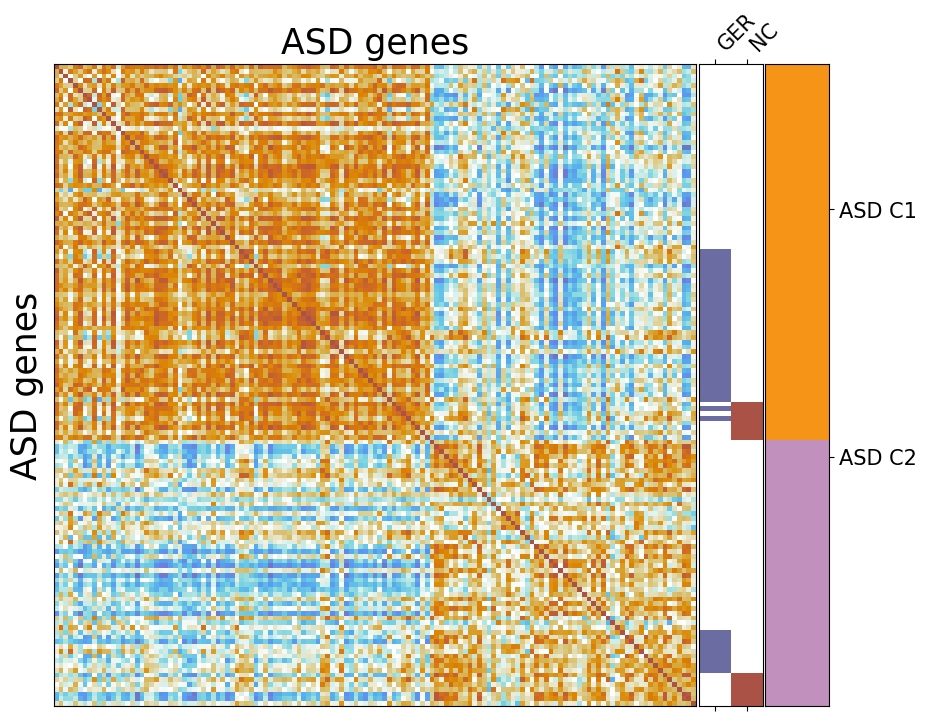

In [45]:
grid2 = np.corrcoef(concat_cortex[genes_tables['Rare ASD']])
fig = plt.figure(figsize=(10,12))
w=0.1
gs = fig.add_gridspec(1,3, wspace=0.01,width_ratios=[1,w,w],height_ratios=[1])
axs = gs.subplots(sharex=False, sharey=False)

cax=axs[0].matshow(grid2[order_dg][:,order_dg],
               cmap=p.cmap_hex,vmin=-1,vmax=1)

# fig.colorbar(cax,orientation="horizontal",
#             anchor=(0.0,0.0),ax=axs[0])
axs[0].set_xticks([])
axs[2].imshow(im_bar)
axs[2].set_xticks([]);
axs[0].set_yticks([]);
axs[0].set_xlabel('ASD genes',fontsize=25)
axs[0].set_ylabel('ASD genes',fontsize=25,)
axs[0].xaxis.set_label_position('top') 
axs[2].set_yticks([30,82])
axs[2].set_yticklabels(['ASD C1','ASD C2'])
axs[2].yaxis.tick_right()
#
axs[1].matshow(go_genes[:,order_dg].T,cmap=p.cmap_hex)
#axs[1].set_xticks([]);

axs[1].set_yticks([]);
axs[1].set_aspect(0.1482)
axs[2].set_aspect(0.1482/2)

#axs[1].set_xlabel('GO')
axs[1].set_xticks([0,1])
axs[1].set_xticklabels(['GER','NC'],rotation=45,ha='left')

fig.savefig('figures/asd_genes_grid.pdf')

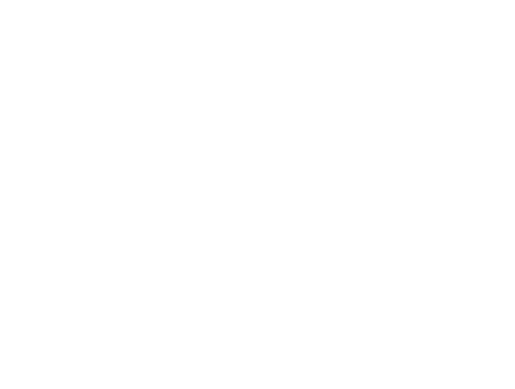

In [46]:
fig,ax = plt.subplots(1)
ax.axis('off')
cbar= fig.colorbar(cax,orientation='horizontal')
cbar.set_label('Correlation (R)')
fig.savefig('figures/cmap_asd_genes_grid.pdf')

In [47]:
disease_eigengene = []
for cluster in np.arange(2):
    disease_eigengene.append(np.mean(concat_cortex[genes_tables['Rare ASD']][labels==cluster],axis=0))

In [38]:
disease_eigen_corrs=proc.corr2_coeff(np.array(disease_eigengene),proc.full_eigengenes_filtered[:,cortex])

In [39]:
perm_stats = np.zeros((1000,2,16))
for perm in np.arange(1000):
    sp = proc.spins[perm]
    perm_stats[perm] = proc.corr2_coeff(np.array(disease_eigengene)[:,sp],proc.full_eigengenes_filtered[:,cortex])
    

In [40]:
from sklearn.metrics import r2_score
var_exp= np.zeros((sum(genes_tables['Rare ASD']),16))
for gi,g in enumerate(concat_cortex[genes_tables['Rare ASD']]):
    for mi,m in enumerate(proc.full_eigengenes_filtered[:,cortex]):
        var_exp[gi,mi] = r2_score(g, m)

In [98]:
v_exp=np.zeros((2,16))
for cluster in np.arange(2):
    v_exp[cluster]=np.median(var_exp[labels==cluster],axis=0)

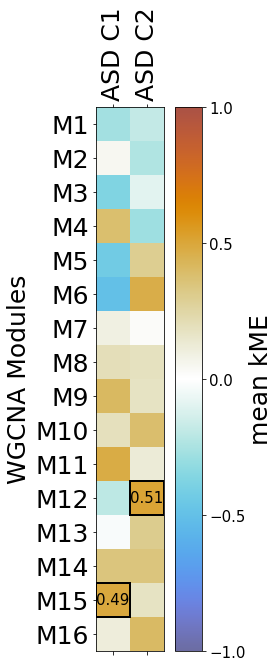

In [107]:
kmes=proc.corr2_coeff(proc.full_eigengenes_filtered[:,cortex],
            concat_cortex[genes_tables['Rare ASD']])
k=[]
for cluster in np.arange(2):
    k.append(np.mean(kmes[:,labels==cluster],axis=1))
#plt.matshow(np.array(k).T,vmin=-1,vmax=1,cmap=p.cmap_hex)
mat = np.array(k).T
fig,ax = plt.subplots(figsize=(2,10))
cax = ax.matshow(mat,
            vmin=-1,vmax=1,cmap=p.cmap_hex)
#n_genes = np.unique(labels,return_counts = True)[1]
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['ASD C1','ASD C2'],ha='center',rotation=90,size=25);
m_labels = list(proc.dictionary_modules.keys())
ax.set_yticks(np.arange(16));
ax.set_yticklabels(m_labels,size=25);
ax.set_ylabel("WGCNA Modules",size=25)
strongest = np.argmax(mat,axis=0)
for x,y in enumerate(strongest):
    pos=np.array([x,y])
    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=2)
    ax.text(pos[0],pos[1],np.round(mat[pos[1],pos[0]],2),ha='center',
           va='center')
    ax.add_patch(r)
cb=fig.colorbar(cax,ticks = np.linspace(-1,1,5),fraction=0.29, pad=0.1,
            )
cb.set_label(label='mean kME',size=25)
fig.savefig('figures/module_kme_ASD.pdf')

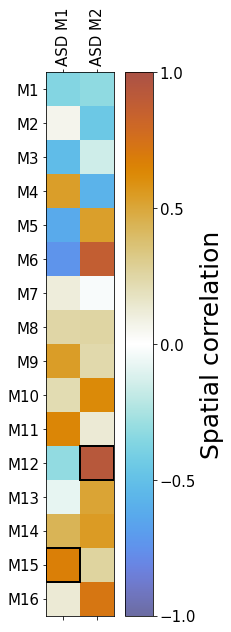

In [100]:
fig,ax = plt.subplots(figsize=(2,10))
cax = ax.matshow(disease_eigen_corrs.T,
            vmin=-1,vmax=1,cmap=p.cmap_hex)
n_genes = np.unique(labels,return_counts = True)[1]
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['ASD M1','ASD M2'],ha='center',rotation=90);
m_labels = list(proc.dictionary_modules.keys())
ax.set_yticks(np.arange(16));
ax.set_yticklabels(m_labels);
strongest = np.argmax(disease_eigen_corrs,axis=1)
for x,y in enumerate(strongest):
    pos=np.array([x,y])
    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=2)
    ax.add_patch(r)
cb=fig.colorbar(cax,ticks = np.linspace(-1,1,5),fraction=0.29, pad=0.1,
            )
cb.set_label(label='Spatial correlation',size=25)


matching gene ids and names...
warning,36 duplicates found


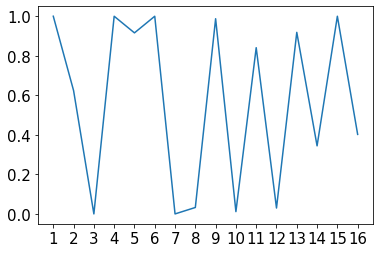

In [60]:
#Abnormally expressed genes in ASD
t=pd.read_excel('asd_haney/SupplementaryTable4.xlsx',sheet_name='All_ARI_Genes')
subset = t[t['Region_with_Greater_Mean_Expression']=='BA17']
subset = subset[subset['Group_Contrast_FDR']<0.05]
ensembls = subset['ensembl_gene_id'].values
gene_names = subset['external_gene_name'].values
indices,mask = get_indices(gene_names,gene_ensembl=ensembls,filter_mask = proc.gene_mask)
gm = np.zeros(np.sum(proc.gene_mask))
gm[indices]=1
f,p = proc.get_enrichments_stats(proc.modules_matrix,gm.reshape(-1,1).T)


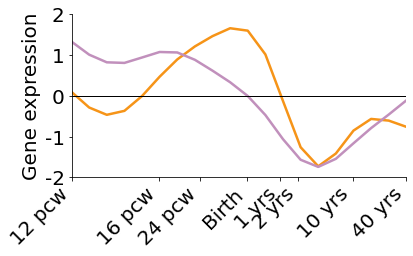

In [62]:
## Time trajectories in depth
#plot each gene trajectory pale and mean trajectory dark thick
indices = np.load('fetal_data/brainspan_indices_full.npy')
#only includes the masked genes
gene_trajectories = np.load('fetal_data/gene_trajectories_full.npy')


xticks=np.load('fetal_data/xticks_brainspan.npy')
xticklabels=np.load('fetal_data/xticklabels_brainspan.npy')

fig,ax = plt.subplots(1,1,figsize=(6,3))
for mi,module in enumerate(['M12','M15']):
    bool_vec = np.zeros(sum(proc.gene_mask),dtype=bool)
    bool_vec[proc.dictionary_modules[module]]=1
    f = np.zeros(len(proc.gene_mask),dtype=bool)
    f[proc.gene_mask]=bool_vec
    bool_brainspan=f[indices]
    std=np.nanstd(gene_trajectories[bool_brainspan],axis=1)
    mean=np.nanmean(gene_trajectories[bool_brainspan],axis=1)
    mask_m = std!=0
    z_g=(gene_trajectories[bool_brainspan][mask_m].T-mean[mask_m])/std[mask_m]
    zz=np.mean(z_g,axis=1)
    #1st PC
    zz=(zz-np.mean(zz))/np.std(zz)
    #ax.plot(z_g,c=module_colors[mi],alpha=0.01);
    ax.plot(zz,c=module_colors[mi],alpha=1,lw=2.5);
ax.set_xticks(xticks);
xticklabels[xticklabels=='0 yrs']='Birth'
ax.set_xticklabels(xticklabels,rotation=45,ha='right',size=20);
ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([-2,-1,0,1,2],size=20)

ax.set_ylim([-2,2])

ax.set_ylabel('Gene expression',size=20)
ax.plot([np.min(xticks)-20,np.max(xticks)],[0,0],c='k',lw=1)
ax.set_xlim([0,19])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('figures/fetal_development_12_15.pdf')

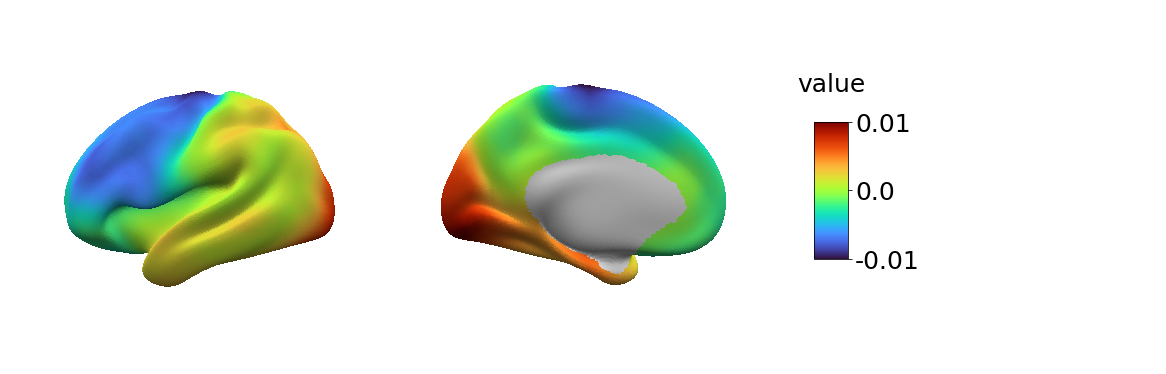

In [63]:
full = np.zeros(len(cortex))
full=proc.full_eigengenes_filtered[14]
msp.plot_surf(surf.darrays[0].data,
             surf.darrays[1].data,
             full,cmap='turbo',mask=~cortex)

/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


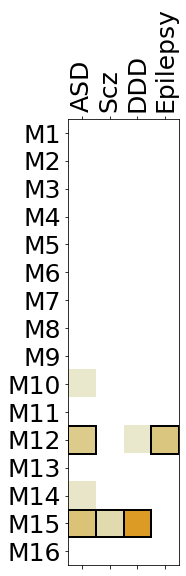

In [64]:
#TODO disease lists table
mat,p=proc.get_enrichment_for_prefix('Rare')
matrix=p
fig,ax=plt.subplots(1,1,figsize=(2,10))
label=['ASD','Scz','DDD','Epilepsy']#ax = fig.add_subplot(gs2[ mi])
#label.extend(cnv_disease_list)
matrix[matrix>0.05]=1
import scripts.paths as p 
from statsmodels.stats.multitest import multipletests
ax.matshow(-np.log10(matrix[proc.new_order.argsort().argsort()]+1e-50),cmap=p.cmap_hex,vmin=-10,vmax=10)
#ax.matshow(matrix.T[new_order],cmap=cmap_hex,vmin=-1,vmax=1)
ax.set_xticks(np.arange(len(label)))
ax.set_xticklabels(label,rotation=90,ha='center',size=25)

ax.set_yticks(np.arange(matrix[new_order.argsort().argsort()].shape[0]));
ax.set_yticklabels(proc.dictionary_modules.keys(),size=25);
#highlight significant boxes
mcorr=np.zeros_like(matrix,dtype=bool)
for mi,m in enumerate(matrix[new_order.argsort().argsort()]):
    mcorr[mi]=multipletests(m)[0]
    

for si,sig_n in enumerate(np.where(mcorr.T)[0]):
    pos=np.array([np.where(mcorr)[1][si],np.where(mcorr)[0][si]])
    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=2)
    ax.add_patch(r)
fig.savefig('figures/disease_table.pdf')


Some functions depend on CIVET, consider installing.


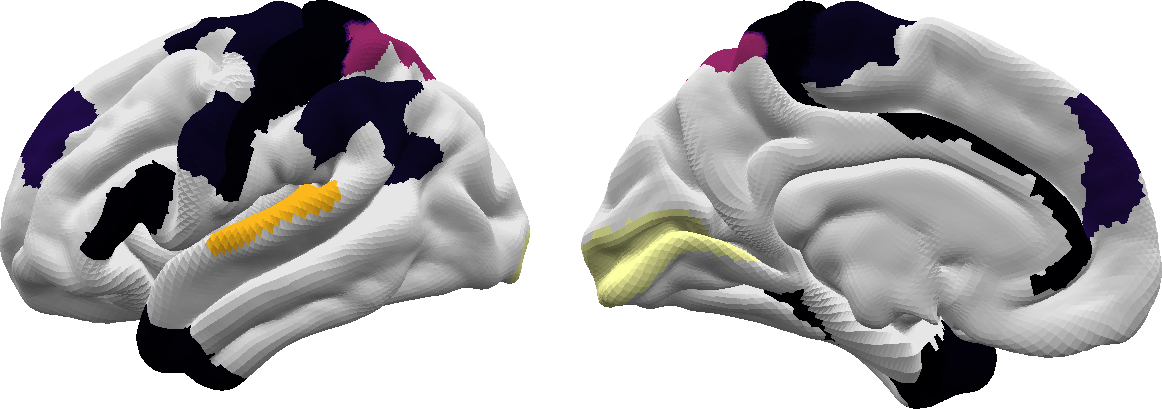

In [37]:
#spin test vs Haney map, include M15.
#DEG Haney expression maps
import scripts.paths as p
import pandas as pd
import matplotlib_surface_plotting as msp
import scripts.plotting_helpers as ph
import importlib
importlib.reload(ph)
from PIL import Image
roi_degs=pd.read_excel('haney_deg.xlsx')
glasser_file=nb.load(os.path.join(p.fs_LR32k_dir,'Glasser_2016.32k.L.label.gii'))
glasser=glasser_file.darrays[0].data
cortex=glasser>0
labels_dict = glasser_file.labeltable.get_labels_as_dict()
inv_labels = {v: k for k, v in labels_dict.items()}
parcellation = np.zeros(len(glasser))-1
mapped = np.zeros(len(glasser),dtype=int)
for k,roi in enumerate(roi_degs.Glasser):
    glasser_rois= roi.split(',')
    for gr in glasser_rois:
        parcellation[glasser==inv_labels[gr]]=k
        mapped[glasser==inv_labels[gr]]=roi_degs.loc[k].DEGs
        
surf=nb.load(os.path.join(p.fs_LR32k_dir,
                                'fs_LR.32k.L.pial.surf.gii'))
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,mapped,rotate=[],cmap='inferno',
              mask=parcellation==-1,cmap_label='N genes\ndiff expressed\nin ASD',vmin=0,vmax=max(mapped),
              filename='figures/haney_degs_cbar.pdf'
             )
im=ph.create_stacked_maps([mapped],surf,cortex,
                          vmin=0,vmax=max(mapped),cmap='inferno',
                          norm=False,mask=parcellation==-1,
                         mask_colour=np.array([0.9,0.9,0.9,1]))
image=Image.fromarray(im)
image.save('figures/haney_degs.png')

image

In [45]:
# eig=14
# parcellation_c=parcellation[cortex]
# vals= parcellate(proc.full_eigengenes_filtered[eig][cortex],parcellation_c,len(roi_degs))
# parcellation = np.zeros(len(glasser))-1
# mapped = np.zeros(len(glasser),dtype=float)
# for k,roi in enumerate(roi_degs.Glasser):
#     glasser_rois= roi.split(',')
#     for gr in glasser_rois:
#         parcellation[glasser==inv_labels[gr]]=k
#         mapped[glasser==inv_labels[gr]]=vals[k]
# im=ph.create_stacked_maps([mapped],surf,cortex,
#                           vmin=min(mapped),vmax=max(mapped),cmap='inferno',
#                           norm=False,mask=parcellation==-1,
#                          mask_colour=np.array([0.9,0.9,0.9,1]))
# image=Image.fromarray(im)
# image

In [42]:
n_perm=10000
spins = np.load(f'spin_dir/spins_{n_perm}.npy')

In [46]:
def parcellate(sn_map, parcels,n_rois):
    """parcellate map"""
    vals = np.zeros(n_rois)
    for k in np.arange(n_rois):
        vals[k] = np.median(sn_map[parcels==k])
    return vals

from netneurotools import stats as nnstats 
def generate_spins(coms,hemi, n_iter=1000):
    """calculate r and p for two distributions
    coms - centres of mass
    hemi - not relevant for one hemi. Just set all to 0.
    n_iter - number of iterations
    """
    spins = nnstats.gen_spinsamples(coms, hemi, n_rotate=n_iter,
                                                  exact=False, seed=1234,
                                                  check_duplicates=False,
                                                  )
    return spins

In [47]:
sphere = nb.load('/data1/allen_surfaces/hcp_surfs/standard_mesh_atlases/L.sphere.32k_fs_LR.surf.gii')
cortex=nb.load(os.path.join('/data1/allen_surfaces/hcp_surfs/','fs_LR32k','Glasser_2016.32k.L.label.gii'))
cortex=cortex.darrays[0].data>0

coords=sphere.darrays[0].data
coords_cortex=coords[cortex]
coms=[]
for com in np.unique(parcellation)[1:]:
    coms.append(np.mean(coords[parcellation==com],axis=0))
coms=np.array(coms)
spins=generate_spins(coms,np.zeros(len(coms)),n_iter=n_perm)


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.8521


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


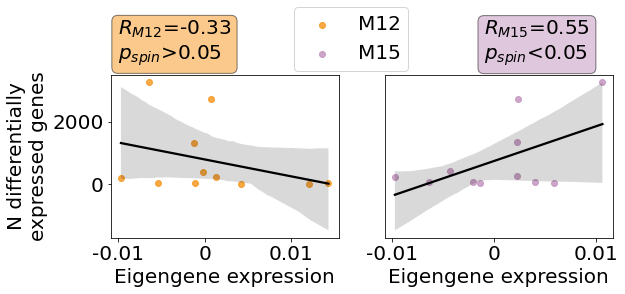

In [54]:
from scipy import stats
import seaborn as sns
fig,ax=plt.subplots(1,2,figsize=(9,3))
parcellation_c=parcellation[cortex]
vals= parcellate(proc.full_eigengenes_filtered[11][cortex],parcellation_c,len(roi_degs))
vals_rois=roi_degs.DEGs
r=np.corrcoef(vals, vals_rois)[0,1]
rs= stats.spearmanr(vals, vals_rois)
spun_r = np.zeros(n_perm)
for p in np.arange(n_perm):
    s=np.random.choice(n_perm)
    spun_vals= vals[spins[:,p]]
    spun_r[p] = np.corrcoef(spun_vals, vals_rois)[0,1]
    
props = dict(boxstyle='round', facecolor=module_colors[0], alpha=0.5)

ax[0].text(-0.01,4000,'$R_{M12}$'+f'={r:.2f}\n'+'$p_{spin}$>0.05',size=20,
       bbox=props)

# vals= parcellate(snv2,parcellation_c,len(roi_degs))
# r2=np.corrcoef(vals.argsort().argsort(), roi_degs.DEGs.argsort().argsort())[0,1]
sns.regplot(vals,vals_rois,color=module_colors[0],ax=ax[0],label='M12',
           fit_reg=False);
sns.regplot(vals,vals_rois,scatter=None,color='k',ax=ax[0]);

print(1-np.mean(r>spun_r))
vals= parcellate(proc.full_eigengenes_filtered[14][cortex],parcellation_c,len(roi_degs))
vals_rois=roi_degs.DEGs
r=np.corrcoef(vals, vals_rois)[0,1]
rs= stats.spearmanr(vals, vals_rois)
spun_r = np.zeros(n_perm)
for p in np.arange(n_perm):
    s=np.random.choice(n_perm)
    spun_vals= vals[spins[:,p]]
    spun_r[p] = np.corrcoef(spun_vals, vals_rois)[0,1]

# vals= parcellate(snv2,parcellation_c,len(roi_degs))
# r2=np.corrcoef(vals.argsort().argsort(), roi_degs.DEGs.argsort().argsort())[0,1]
sns.regplot(vals,vals_rois,color=module_colors[1],ax=ax[1],label='M15',
           fit_reg=False);
sns.regplot(vals,vals_rois,scatter=None,color='k',ax=ax[1]);

ax[0].set_xticks([-1e-2,0,1e-2])
ax[0].set_xticklabels([-1e-2,0,1e-2],size=20)
ax[1].set_xticks([-1e-2,0,1e-2])
ax[1].set_xticklabels([-1e-2,0,1e-2],size=20)

ax[0].set_yticks([0,2000])
ax[0].set_yticklabels([0,2000],size=20)
ax[1].set_yticks([])
ax[1].set_ylabel('')

ax[0].set_xlabel('Eigengene expression',size=20)

ax[1].set_xlabel('Eigengene expression',size=20)
ax[0].set_ylabel('N differentially\nexpressed genes',size=20)
props = dict(boxstyle='round', facecolor=module_colors[1], alpha=0.5)

ax[1].text(-0.001,4000,'$R_{M15}$'+f'={r:.2f}\n'+'$p_{spin}$<0.05',size=20,
        bbox=props)
fig.legend(fontsize=20,bbox_to_anchor=(0.6,1.24))
fig.savefig('figures/haney_scatter.pdf')

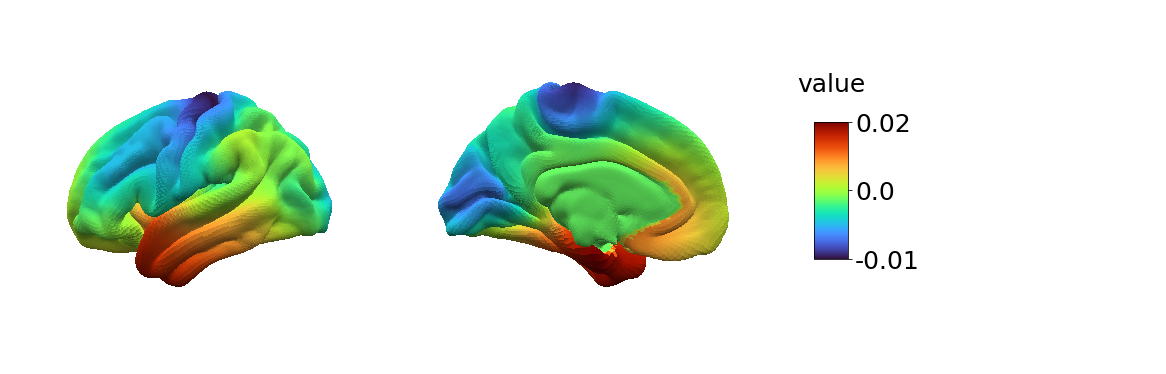

In [49]:
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,proc.full_eigengenes_filtered[11],cmap='turbo',
              
             )

In [50]:
vals= parcellate(proc.full_eigengenes_filtered[11][cortex],parcellation_c,len(roi_degs))
vals_rois=roi_degs.DEGs
r=np.corrcoef(vals, vals_rois)[0,1]
rs= stats.spearmanr(vals, vals_rois)
spun_r = np.zeros(n_perm)
for p in np.arange(n_perm):
    s=np.random.choice(n_perm)
    spun_vals= vals[spins[:,p]]
    spun_r[p] = np.corrcoef(spun_vals, vals_rois)[0,1]
np.mean(r<spun_r),r

(0.8487, -0.33356645758659187)